# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Devoir 3 - Régression logistique ( 15 points )

Le présent devoir concerne les notions de la régression logistique vues au Chapitre 3 du cours. 

## Devoir effectué par

Paré, Marie-Christine - 1901114

NOM, PRÉNOM - MARTICULE

**Déclaration d’intégrité relative au plagiat**

Nous certifions sur l’honneur :
- Que les résultats décrits dans ce rapport sont l’aboutissement de notre travail.
- Que nous sommes les auteurs de ce rapport.
- Que nous n'avons pas utilisé des sources ou résultats tiers sans clairement les citer et les référencer selon les règles bibliographiques préconisées.

Nous déclarons que ce travail ne peut être soupçonné de plagiat.


# Contexte : Classification des tumeurs

Une tumeur est un groupe de cellules anormales qui forment une masse. Les tumeurs se développent et se comportent différemment, selon qu’elles soient cancéreuses (malignes), non cancéreuses (bénignes). Le but du concours sera de prédire si une tumeur est bénigne (0) ou maligne (1) en fonction des caractéristiques suivantes récoltées par imagerie médicale : 

- radius : distance moyenne entre le centre de la tumeur et son périmètre (en mm) ;
- texture : écart-type des niveaux de gris représentant l'image de la tumeur ;
- perimeter : périmètre de la tumeur (en mm) ;
- area : superficie de la tumeur (en mm²) ;
- smoothness : variation locale normalisée en fonction du radius (indice de rugosité) ;
- compactness : perimeter^2 / area -1 (indice de compacité) ;
- symmetry : mesure de symétrie ; 
- fractal dimension : ("coastline approximation" - 1).

Les données sont issues de 569 images. Vous aurez à partitionner le jeu de données en ensemble d'entraînement et en ensemble de validation. Le code est fourni dans les premières cellules de code. La partition est fonction de vos numéros de matricules, alors vous avez tous des échantillons uniques.

# Consignes

- Le devoir doit être remis sur Moodle **avant 23h59 le lundi 22 février 2020.** Les retards ne seront pas tolérés car le solutionnaire sera publié dès mardi.
- Le devoir a une pondération de 7.5%.
- Écrivez vos noms et vos matricules dans l'espace prévu à cet effet de cette cellule et dans la cellule pour le partitionnement.
- Vous pouvez compléter le devoir en équipe de deux personnes. Dans ce cas, un seul fichier par équipe doit être remis. Pour vous aider à trouver un coéquipier, le canal de discussion *#trouver_un_coéquipier* a été créé sur Slack.
- Le devoir doit être complété dans le présent calepin Jupyter en ajoutant autant de cellules de texte et de code que nécessaires. Vous remettrez ce fichier en format *.ipynb*. Le nom du fichier doit être *matricule1_matricule2_devoir3.ipynb*.
- N'utilisez que les librairies introduites à la cellule suivante.
- Vous pouvez utiliser directement les fonction `auc()` et `rocplot()` fournies. 

## Chargement des libairies

In [92]:
using CSV
using Combinatorics
using DataFrames
using Dates
using GLM
using Gadfly
using MLBase
using Random
using Statistics

## Écriture des matricules

Écrivez vos matricules ici. Si vous êtes seule, laissez le matricule2 à 0.

In [93]:
matricule1 = 1901114
matricule2 = 1894397

1894397

In [94]:
"""
    auc(gt::Array{<:Real}, scores::Array{<:Real})

Compute the area under the ROC curve based on the ground truth `gt` and the success probability `scores`.

See also `roc()` of MLBase. 
"""
function auc(gt::Array{<:Real},scores::Array{<:Real})
   
    # Compute the ROC curve for 100 equally spaced thresholds - see `roc()` 
    r = roc(gt, scores)
    
    # Compute the true positive rate and false positive rate
    tpr = true_positive_rate.(r)
    fpr = false_positive_rate.(r)
    
    # Numerical computation of the area under the ROC curve
    p = sortperm(fpr)
    
    permute!(tpr,p)
    permute!(fpr,p)
    
    area = 0.0
    
    for i in 2:length(tpr)
        dx = fpr[i] - fpr[i-1]
        dy = tpr[i] - tpr[i-1]
        area += dx*tpr[i-1] + dx*dy/2
    end
    
    return area
    
end


"""
    rocplot(gt::Array{<:Real},scores::Array{<:Real})

Show the ROC curve corresponding to the ground truth `gt` and the success probability `scores`.

The curve is computed for 100 equally spaced thresholds.
"""
function rocplot(gt::Array{<:Real},scores::Array{<:Real})
    
    # Compute the ROC curve for 100 equally spaced thresholds - see `roc()` 
    r = roc(gt, scores)
    
    # Compute the true positive rate and false positive rate
    tpr = true_positive_rate.(r)
    fpr = false_positive_rate.(r)
    
    return plot(x=fpr, y=tpr, Geom.line, Geom.abline(color="red", style=:dash),
        Guide.xlabel("False Positive Rate"), Guide.ylabel("True Positive Rate"))
    
end

rocplot

## Chargement et partitionnement des données

#### Chargement des données

In [95]:
data = CSV.read("data.csv", DataFrame)
first(data, 10)

,id,radius,texture,perimeter,area,smoothness,compactness,concavity
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001
2,2,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869
3,3,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974
4,4,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414
5,5,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198
6,6,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578
7,7,18.25,19.98,119.6,1040.0,0.09463,0.109,0.1127
8,8,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366
9,9,13.0,21.82,87.5,519.8,0.1273,0.1932,0.1859


#### Partitionnement en ensemble d'entraînement et de validation

Le partitionnement est le suivant :
- ensemble d'entraînement : 80%
- ensemble d'entraînement : 20%

In [96]:
n = Int(round(nrow(data)*.8))

Random.seed!(matricule1+matricule2)

train_id = sample(1:nrow(data), n, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
first(train,10)

,id,radius,texture,perimeter,area,smoothness,compactness,concavity
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001
2,2,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869
3,4,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414
4,5,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198
5,6,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578
6,7,18.25,19.98,119.6,1040.0,0.09463,0.109,0.1127
7,8,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366
8,9,13.0,21.82,87.5,519.8,0.1273,0.1932,0.1859
9,10,12.46,24.04,83.97,475.9,0.1186,0.2396,0.2273


In [97]:
valid = data[valid_id, :]
first(valid,10)

,id,radius,texture,perimeter,area,smoothness,compactness,concavity
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974
2,15,13.73,22.61,93.6,578.3,0.1131,0.2293,0.2128
3,16,14.54,27.54,96.73,658.8,0.1139,0.1595,0.1639
4,17,14.68,20.13,94.74,684.5,0.09867,0.072,0.07395
5,18,16.13,20.68,108.1,798.8,0.117,0.2022,0.1722
6,21,13.08,15.71,85.63,520.0,0.1075,0.127,0.04568
7,25,16.65,21.38,110.0,904.6,0.1121,0.1457,0.1525
8,34,19.27,26.47,127.9,1162.0,0.09401,0.1719,0.1657
9,36,16.74,21.59,110.1,869.5,0.0961,0.1336,0.1348


## Exercice 1 - Analyse exploratoire sommaire (3 points)

On s'intéresse ici à illustrer le lien entre le caractère bénin (:diagnosis = 0) ou malin (:diagnosis = 1) des tumeurs en fonction du rayon de celles-ci. **N'ajustez pas de modèle statistique pour répondre aux questions de l'exercice 1.**

Cet exercice ne constitue que la première étape d'une analyse exploratoire sommaire. Je vous encourage à poursuivre l'analyse exploratoire pour mieux cerner le problème général. 

#### (a) Vérifiez à l'aide d'un graphique approprié si le rayon de la tumeur semble influencer le diganostic.

Choisissez le graphique qui vous semble le plus éloquent. Imaginez que vous devez le présentez à un groupe de médecins qui ne connaissent rien à la statistique et à l'apprentissage machine.

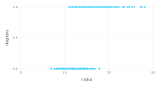

In [98]:
Gadfly.set_default_plot_size(16cm, 9cm)
plot(data,x=:radius,y=:diagnosis,Geom.point)

#### (b) Parmi les tumeurs dont le rayon excède 12 mm, calculez la proportion empirique des tumeurs malignes.

In [99]:
df=filter(row -> row.radius > 12, data)
Nₜ=length(df.radius) # Nombre total de tumeur avec un rayon > 12 mm

maligne=filter(row -> row.diagnosis ==1, df)
Nₘ=length(maligne.radius)

pₘ=(Nₘ/Nₜ)*100

resultat= round.(pₘ, digits=2)
println("La proportion des tumeurs malignes ayant un rayon excédant 12 mm est $resultat %" )


La proportion des tumeurs malignes ayant un rayon excédant 12 mm est 51.76 %


#### (c) Seriez-vous en mesure de calculez le rayon pour lequel 95% des tumeurs sont malignes ?

Si oui, calculez-le. Sinon, expliquez pourquoi c'est difficile.

## Exercice 2 - Modélisation du diagnostic en fonction du rayon (8 points)

#### a) Estimation des paramètres

En utilisant comme seule variable explicative le rayon de la tumeur, estimez les paramètres avec les données de l'ensemble d'entraînement du modèle de régression logistique en utilisant le fonction de lien logit. Donnez explicitement β̂₀ et β̂₁.

**Suggestion :** Utilisez la fonction `glm()` de la librairie *GLM.jl*.

β̂₀=-14.592470599030188
β̂₁=0.9828050557733468


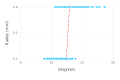

In [165]:
x₁=train.radius
Y=train.diagnosis

df=DataFrame(x₁=x₁,Y=Y)

# Modèle de régression logistique
M = glm(@formula(Y ~ x₁), df,  Bernoulli(), LogitLink())

β̂ = coef(M)

println("β̂₀=",β̂[1])
println("β̂₁=",β̂[2])

#Graphique
Gadfly.set_default_plot_size(12cm, 8cm)
plot(df, x=:x₁, y=:Y, Geom.point, 
    intercept = [β̂[1]], slope = [β̂[2]], Geom.abline(color="red", style=:dash),
    Coord.cartesian(xmin=0, xmax=30),
   Guide.xlabel(" Diagnosis "),
    Guide.ylabel("Radius (mm)"))

#### b) Si une tumeur possède un rayon de 12 mm, quelle est l'estimation de la probabilité quelle soit maligne ?

In [166]:
#Estimation de la probabilité pour un rayon de 12 mm
x₀=[1 12.0]

θ̂₀ = predict(M,x₀)
θ̂₀=θ̂₀[1]*100
θ̂₀=round.(θ̂₀,digits=2)
println("L'estimation de la probabilité qu'une tumeur d'un rayon de 12 mm est de $θ̂₀ %")


L'estimation de la probabilité qu'une tumeur d'un rayon de 12 mm est de 5.74 %


#### c) Quelle est le rayon pour lequel on est sûr à 80% que la tumeur est maligne ?

Expliquez bien les détails de votre calcul.

Le rayon seuil est de 16.26 mm


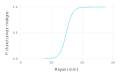

In [197]:
# Pour chacune des observations, la probabilité que la tumeur soit maligne
θ̂ = predict(M)

dF=DataFrame(x₁=x₁,θ̂=θ̂)
sort!(dF)
first(dF,5)
R80=filter(row -> row.θ̂ >= 0.80, dF)
res=round.(R80[1,1],digits=2)
println("Le rayon seuil est de $res mm")

#Graphique
Gadfly.set_default_plot_size(12cm, 8cm)
plot(dF, x=:x₁, y=:θ̂, Geom.line,
Guide.xlabel("Rayon (mm)"),
Guide.ylabel("P. d'une tumeur maligne "))

#### d) Évaluation de la qualité du modèle

Tracez la courbe ROC du modèle et calculez l'aire sous la courbe. Donnez une interprétation pratique de ces mesures.

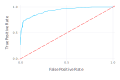

In [207]:
#Courbe ROC 
rocplot(df.Y, θ̂)

In [218]:
A = auc(df.Y, θ̂)

A=round.(A,digits=2)

if 0.9 <= A < 1.0
    println("L'aire sous la courbe est de $A, donc le modèle est excellent.")
    
elseif 0.8 <= A < 0.9
    println("L'aire sous la courbe est de $A, donc le modèle est bon.")
        
elseif 0.7 <= A < 0.8
    println("L'aire sous la courbe est de $A, donc le modèle est moyen.")

elseif 0.6 <= A < 0.7
    print("L'aire sous la courbe est de $A, donc le modèle est faible.")

elseif 0.5 <= A <= 0.6
    print("L'aire sous la courbe est de $A, donc le modèle est mauvais")
                    
end


L'aire sous la courbe est de 0.93, donc le modèle est excellent.


#### e) Règle de décision

Laquelle des règles suivantes est la plus appropriée pour prédire l'occurrence d'une surverse :

- Règle 1 : si le rayon dépasse 12 *mm*.
- Règle 2 : si le rayon dépasse 15 *mm*.
- Règle 3 : si le rayon dépasse 17.2 *mm*.
- Règle 4 : si le rayon dépasse 19.5 *mm*.

Justifiez bien quantitativement votre réponse. Utilisez les mesures de qualité qui vous semblent les plus appropriées.

#### f) Justification de la méthodologie

Un médecin vous regarde incrédule faire la présentation de votre modèle et vous demande à quoi ça sert de faire aussi compliqué. D'après lui, après avoir vu le graphique présenté à l'analyse exploratoire, il est en mesure d'estimer le rayon à partir de lequel les tumeur peuvent être étiquetés comme malignes. À l'oeil, il estime le seuil 15 *mm*. Comment pouvez justifier l'utilisation de votre approche ? 

**Note :** C'est une question typique que vous vous ferez certainement poser !

## Exercice 3 - Prédiction des diagnostics (4 points)

Identifiez les variables permettant de mieux prédire les diagnostics. Vous devez obligatoirement utilisée la régression logistique mais les détails de la méthodologie sont laissés à votre discrétion. Vous pouvez utiliser comme bon vous semble la courbe ROC, l'échantillon d'entraînement, l'échantillon d'entraînement, etc.

**Note :** Vous ne devez ici qu'identifier les variables explicatives les plus importantes pour la prédiction des diagnositics. Vous ne devez pas spécifier la règle de décision optimale.

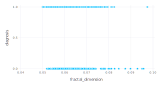

In [237]:
Gadfly.set_default_plot_size(16cm, 9cm)

#plot(data,x=:radius,y=:diagnosis,Geom.point)
#plot(data,x=:texture,y=:diagnosis,Geom.point) # à rejeter
#plot(data,x=:perimeter,y=:diagnosis,Geom.point)
#plot(data,x=:area,y=:diagnosis,Geom.point)
#plot(data,x=:smoothness,y=:diagnosis,Geom.point) # À rejeter
#plot(data,x=:compactness,y=:diagnosis,Geom.point) #à rejeter
#plot(data,x=:concavity,y=:diagnosis,Geom.point) # à rejeter
#plot(data,x=:concave_points,y=:diagnosis,Geom.point)
#plot(data,x=:symmetry,y=:diagnosis,Geom.point)
#plot(data,x=:fractal_dimension,y=:diagnosis,Geom.point) #À rejeter

